# **Milestone 4: Baseline Pricing Engine**

Loaded data from: cleaned_dynamic_pricing.csv
Detected columns:
 Price: historical_cost_of_ride
 Ride: number_of_riders
 Time: time_of_booking


💰 Static Revenue: 22,514,545.02
⚡ Dynamic Revenue: 27,025,385.95
📈 Simulated Revenue Lift: 20.04%


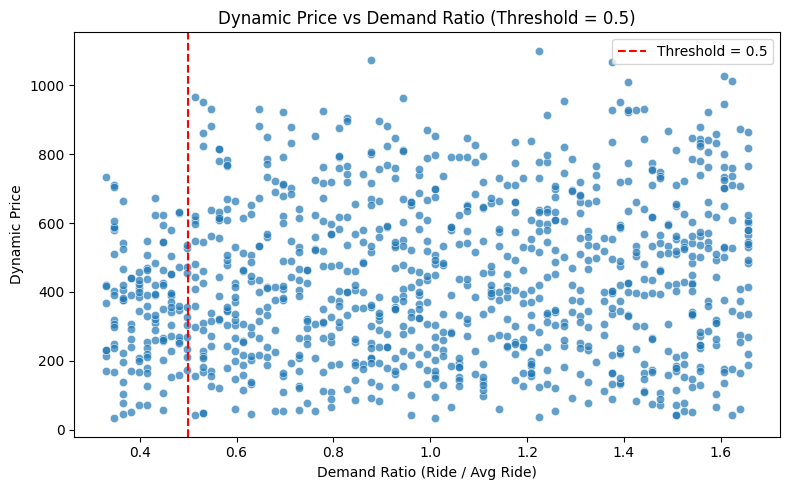

C:\Users\ishwa\AppData\Local\Temp\ipykernel_5548\2458928037.py:155: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Static', 'Dynamic'], y=[static_rev, dynamic_rev], palette='viridis')


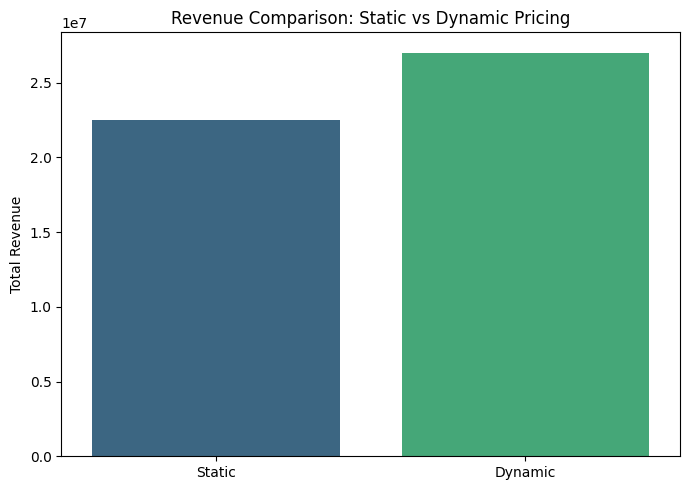

✅ Results saved as 'baseline_threshold_pricing_updated.csv'


In [2]:
# ============================================================
# 🧩 Milestone 4: Threshold-Based Baseline Pricing Engine (Enhanced with Categorical Columns)
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Load cleaned dataset with sensible fallbacks ---
paths_to_try = ["cleaned_csv_data.csv", "cleaned_dynamic_pricing.csv", "dynamic_pricing.csv", "baseline_pricing_output.csv"]
loaded = False
for p in paths_to_try:
    if os.path.exists(p):
        data = pd.read_csv(p)
        print(f"Loaded data from: {p}")
        loaded = True
        break

if not loaded:
    raise FileNotFoundError("❌ Could not find any of the expected input files.")

# Normalize column names
data.columns = data.columns.str.strip().str.lower().str.replace(' ', '_')
cols = list(data.columns)

# Helper: find likely matching column name
def find_col(cols, candidates):
    cols_lower = [c.lower() for c in cols]
    for cand in candidates:
        if cand.lower() in cols_lower:
            return cols[cols_lower.index(cand.lower())]
    for cand in candidates:
        for c in cols:
            if cand.lower() in c.lower() or c.lower() in cand.lower():
                return c
    return None

# Detect price, ride, and time columns
price_col = find_col(cols, ['price', 'launched_price', 'cost', 'fare'])
ride_col = find_col(cols, ['ride', 'rides', 'num_riders', 'number_of_riders'])
time_col = find_col(cols, ['time', 'time_of_booking', 'booking_time'])

print(f"Detected columns:\n Price: {price_col}\n Ride: {ride_col}\n Time: {time_col}\n")

# Ensure numeric
for c in [price_col, ride_col]:
    data[c] = pd.to_numeric(data[c], errors='coerce')
data.dropna(subset=[price_col, ride_col], inplace=True)

# -------------------------------
# Add Missing Columns
# -------------------------------

# Location category (Urban/Suburban)
if 'location_category' not in data.columns:
    data['location_category'] = np.where(np.random.rand(len(data)) > 0.5, 'Urban', 'Suburban')

# Customer loyalty status (Regular/Silver)
if 'customer_loyalty_status' not in data.columns:
    data['customer_loyalty_status'] = np.where(np.random.rand(len(data)) > 0.6, 'Silver', 'Regular')

# Time of booking (Morning/Evening/Night)
if 'time_of_booking' not in data.columns:
    times = ['Morning', 'Evening', 'Night']
    data['time_of_booking'] = np.random.choice(times, size=len(data))

# -------------------------------
#  Ensure text columns are string-typed and normalized before using .str
# -------------------------------
for _col in ['location_category', 'customer_loyalty_status', 'time_of_booking']:
    if _col in data.columns:
        # convert to string and strip whitespace to make .str operations safe
        data[_col] = data[_col].astype(str).str.strip()
    else:
        # ensure column exists (empty string) so downstream code is robust
        data[_col] = ''

# Add boolean flag columns for these (True/False)
data['is_urban'] = data['location_category'].str.lower().eq('urban')
data['is_silver'] = data['customer_loyalty_status'].str.lower().eq('silver')
data['is_peak_hour'] = data['time_of_booking'].str.lower().isin(['morning', 'evening'])

# -------------------------------
# 1️⃣ Calculate Demand Ratio
# -------------------------------
avg_ride = data[ride_col].mean() or 1
data['demand_ratio'] = data[ride_col] / avg_ride

# -------------------------------
# 2️⃣ Apply Rule-Based Pricing with Threshold = 0.5
# -------------------------------
THRESHOLD = 0.5

def rule_based_pricing(row):
    p = float(row[price_col])

    # Time-based adjustment
    tval = str(row.get(time_col or 'time_of_booking', '')).lower()
    if 'morning' in tval or 'evening' in tval:
        p *= 1.10  # peak hours
    elif 'night' in tval:
        p *= 0.90  # off-peak

    # Demand-based adjustment
    if row['demand_ratio'] > THRESHOLD:
        p *= 1.20  # high demand
    else:
        p *= 0.85  # low demand

    # Loyalty discount
    if row.get('is_silver', False):
        p *= 0.95  # small discount for silver members

    # Urban multiplier
    if row.get('is_urban', False):
        p *= 1.05  # urban cost slightly higher

    return p

data['dynamic_price'] = data.apply(rule_based_pricing, axis=1)

# -------------------------------
# 3️⃣ Compute Revenue & Lift
# -------------------------------
data['static_revenue'] = data[price_col] * data[ride_col]
data['dynamic_revenue'] = data['dynamic_price'] * data[ride_col]

static_rev = data['static_revenue'].sum()
dynamic_rev = data['dynamic_revenue'].sum()
lift = ((dynamic_rev - static_rev) / static_rev) * 100 if static_rev != 0 else np.nan

print(f"\n💰 Static Revenue: {static_rev:,.2f}")
print(f"⚡ Dynamic Revenue: {dynamic_rev:,.2f}")
print(f"📈 Simulated Revenue Lift: {lift:.2f}%")

# -------------------------------
# 4️⃣ Visualizations
# -------------------------------

# Scatter plot: Demand ratio vs Dynamic price
plt.figure(figsize=(8,5))
sns.scatterplot(x='demand_ratio', y='dynamic_price', data=data, alpha=0.7)
plt.axvline(THRESHOLD, color='red', linestyle='--', label=f'Threshold = {THRESHOLD}')
plt.title("Dynamic Price vs Demand Ratio (Threshold = 0.5)")
plt.xlabel("Demand Ratio (Ride / Avg Ride)")
plt.ylabel("Dynamic Price")
plt.legend()
plt.tight_layout()
plt.show()

# Comparison: Static vs Dynamic Revenue
plt.figure(figsize=(7,5))
sns.barplot(x=['Static', 'Dynamic'], y=[static_rev, dynamic_rev], palette='viridis')
plt.title("Revenue Comparison: Static vs Dynamic Pricing")
plt.ylabel("Total Revenue")
plt.tight_layout()
plt.show()

# -------------------------------
# 5️⃣ Save Results
# -------------------------------
out_path = "baseline_threshold_pricing_updated.csv"
data.to_csv(out_path, index=False)
print(f"✅ Results saved as '{out_path}'")
